# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tqdm import tqdm_notebook
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import re
import copy
import geopy.geocoders
from geopy.geocoders import Nominatim
import difflib
from matplotlib.lines import Line2D

In [2]:
# Load financial secrecy index file
fsi_rankings = pd.read_excel('Resource_files/FSI-Rankings.xlsx')

# Load in scraped data

In [3]:
# Load positive cases
ml_comps = pd.read_csv('ml_companies.csv')
ml_officers = pd.read_csv('ml_officers.csv')
ml_psc = pd.read_csv('ml_psc.csv')
ml_filings = pd.read_csv('ml_filings.csv')

In [4]:
# Load negative cases
non_ml_comps = pd.read_csv('non_ml_companies.csv')
non_ml_officers = pd.read_csv('non_ml_officers.csv')
non_ml_psc = pd.read_csv('non_ml_psc.csv')
non_ml_filings = pd.read_csv('non_ml_filings.csv')

In [5]:
# Combine positive and negative samples
comps_df = pd.concat([non_ml_comps, ml_comps], sort=False).reset_index(drop=True)
officers_df = pd.concat([non_ml_officers, ml_officers], sort=False).reset_index(drop=True)
psc_df = pd.concat([non_ml_psc, ml_psc], sort=False).reset_index(drop=True)
filings_df = pd.concat([non_ml_filings, ml_filings], sort=False).reset_index(drop=True)

In [6]:
# Check shape of positive samples
ml_comps.shape

(4893, 12)

In [7]:
# Check shape of negative samples
non_ml_comps.shape

(4893, 12)

# Clean companies data

In [8]:
# Examine companies dataframe
comps_df.head(2)

,name,address,kind,company_number,creation_date,dissolved_date,active_officers,inactive_officers,resigned_officers,active_psc,ceased_psc,ml
0,s & r management consultants ltd,"8 Moorland View Off Street Lane, Moortown Leed...",ltd,11074958,2017-11-21,NaN,2,0,0,1,0,0
1,shl solutions limited,17 Hedley Crescent Wakefield,ltd,08428171,2013-03-04,NaN,4,0,1,3,0,0


In [100]:
# Check for null values
comps_df.isnull().sum()

name                    0
address                 1
kind                    0
company_number          0
creation_date           0
dissolved_date       6119
active_officers         0
inactive_officers       0
resigned_officers       0
active_psc              0
ceased_psc              0
ml                      0
dtype: int64

In [101]:
# Replace dissolved date null values
comps_df.address.fillna('na', inplace=True)

In [102]:
# Convert all strings to lowercase
comps_df['name'] = comps_df['name'].apply(lambda x: x.lower())
comps_df['address'] = comps_df['address'].apply(lambda x: x.lower())

In [103]:
# Group similar addresses
# Common suffixes for street address
street_alternatives =\
'street|road|drive|lane|close|way|court|avenue|square|parade|view|mews|place|grove|yard|park|crescent|str|gate'

# Extract all unique addresses in use
unique_addresses = comps_df.address.unique()

# Define empty list for groupings of similar addresses
address_groups = []

# Iterate through unique addresses
for i in tqdm_notebook(range(len(unique_addresses))):
    # Define list for verified matches 
    select_matches = []
    
    # Select current address
    unique_address = unique_addresses[i]
    
    # Formulat regex to extract street address
    pattern = re.compile('([0-9-]+[a-z]?)[\s]((?:\D*?)(?:{}))'.format(street_alternatives))
    
    # Use fuzzy matching to create subset of similar addresses
    matches = difflib.get_close_matches(unique_address, unique_addresses, n=10, cutoff=0.7)
    
    # For addresses with at least one match
    if len(matches)>1:    
        try:
            # Extract street name and number
            street = re.findall(pattern, unique_address)[0][1]
            street_num = [re.findall(pattern, unique_address)[0][0]]

            # For addresses with number range, extract both numbers
            if '-' in street_num[0]:
                street_num = street_num[0].split('-')

            # Iterate through fuzzy matches
            for match in matches:
                # Verify that street name and number match and append to verified matches
                if (street in match)&(any(num in match for num in street_num)): 
                    select_matches.append(match)
        except:
            pass
        address_groups.append(select_matches)

In [104]:
# Combine common all variation groups with common addresses
merged = []
address_mapper = {}

# Iterate through groups of address variations
for address_group in address_groups:
    # Iterate through each variation
    for i, merged_group in enumerate(merged):
        # Check if any of the variations already in merged group
        if any(address in merged_group for address in address_group):
            # Only add variations which are not already in the merged group
            new_addresses = [address for address in address_group if address not in merged_group]
            merged[i] += new_addresses
            break
    else:
        # If none of variations exist in merged group yet, add all
        merged.append(address_group)

# Create address mapper dictionary
for i in range(len(merged)):
    # For address groups with at least one variation
    if len(merged[i])>1:
        # Take the shortest variation to be the new universal address
        val = sorted(merged[i], key=len)[0]
        # Iterate through each variation
        for key in merged[i]:
            # Check it is not the same as the new name to replace with
            if key != val:
                # Map old variation to new replacement
                address_mapper[key] = val
    
# Replace grouped similar address with single address
comps_df.address.replace(address_mapper, inplace=True)

In [105]:
# Convert dates to datetime
comps_df.creation_date = pd.to_datetime(comps_df.creation_date, format='%Y-%m-%d')
comps_df.dissolved_date = pd.to_datetime(comps_df.dissolved_date, format='%Y-%m-%d')

In [106]:
# Reset index
comps_df.reset_index(drop=True, inplace=True)

# Clean officers data

In [107]:
# Examine officers dataframe
officers_df.head(2)

,company_number,name,role,type,status,country,address
0,11074958,"HUSSAIN, Riffat",secretary,company,active,United Kingdom,"Moorland View Off Street Lane, Moortown Leeds ..."
1,11074958,"HUSSAIN, Shahzad Ghulam",director,person,active,British,"Moorland View Off Street Lane, Moortown Leeds ..."


In [108]:
# Check for null values
officers_df.isnull().sum()

company_number       0
name                 0
role                 0
type                 0
status               0
country           3582
address              3
dtype: int64

In [109]:
# On inspection, all officers with missing address are people not companies so unlikely to have common address with other 
# officers, therefore opt to remove nulls for missing addresses
officers_df.address.fillna('na', inplace=True)

In [110]:
# Convert all strings to lowercase
officers_df['name'] = officers_df['name'].apply(lambda x: x.lower())
officers_df['role'] = officers_df['role'].apply(lambda x: x.lower())
officers_df['address'] = officers_df['address'].apply(lambda x: x.lower())

In [111]:
# Infer missing countries
# Turn off timeout
geopy.geocoders.options.default_timeout = None
geolocator = Nominatim(user_agent="geo_locator")

# Reset index
officers_df.reset_index(drop=True, inplace=True)

# Iterate through officers
for i in tqdm_notebook(range(officers_df.shape[0])):
    # Check if country is null or blank
    if pd.isnull(officers_df.loc[i,'country']) or officers_df.loc[i,'country']==' ':   
        # Check for common UK towns
        if any(city in officers_df.loc[i,'address'].lower() for city in ['london', 'liverpool', 'manchester', 
                                                                         'cardiff', 'edinburgh', 'glasgow', 
                                                                         'warwick', 'sutton', 'leicester', 
                                                                         'birmingham', 'bristol', 'bedford', 
                                                                         'enfield', 'epping']): 
            officers_df.loc[i,'country'] = 'uk'

        # Check if in Moscow
        elif 'moscow' in officers_df.loc[i,'address'].lower():
            officers_df.loc[i,'country'] = 'Russia'

        # Try geolocator to infer country
        else:
            geopy.geocoders.options.default_timeout = None
            geolocator = Nominatim(user_agent="geo_locator")
            try:
                geoloc = geolocator.geocode(officers_df.loc[i, 'address'])[0].split(', ')[-1]
            except:
                geloc = ''
            officers_df.loc[i, 'country'] = geoloc

In [112]:
# Unify country names
# Replace UK variations
pattern = '|'.join(['England', 'Northern Ireland', 'Scotland', 'English', 'United Kingdom', 'Wales', 'British', 
                    'Northern Irish', 'Scottish', 'Welsh', 'Jersey', 'Uk'])
officers_df.loc[:, 'country'] = officers_df.country.str.replace(pattern, 'UK')

# Convert to lower case
officers_df.loc[:, 'country'] = officers_df.country.str.lower()

# Define replacements for typos, outdated names and country variations
replace_dict = {'United Kingdom':'UK', 'Ukrainian':'Ukraine', 'Russian':'Russia', 'Lithuanian':'Lithuania', 
                'Canadian':'Canada','American':'united states', 'Azerbaijani':'Azerbaijan', 
                'Belarusian':'Belarus', 'turks &caicos islands':'turks and caicos islands',
                'Kazakh':'Kazakhstan', 'Swiss':'Switzerland', 'German':'Germany', 'Uzbek':'Uzbekistan', 
                'Bulgarian':'Bulgaria', 'Cypriot':'Cyprus', 'Georgian':'Georgia', 'Latvian':'Latvia', 
                'Moldovan':'Moldova', 'Algerian':'Algeria', 'Norwegian':'Norway', 'Saudi Arabian':'Saudi Arabia',
                'Czech':'Czech Republic', 'Israeli':'Israel', 'Estonian':'Estonia', 'Pakistani':'Pakistan',
                'Citizen Of Bosnia And Herzegovina':'Bosnia And Herzegovina', 'Romanian':'Romania', 
                'Iranian':'Iran', 'Indian':'India', 'Vietnamese':'Vietnam', 'Spanish':'Spain',
                'Citizen Of Seychelles':'Seychelles', 'Italian':'Italy', 'French':'France', 'Belgian':'Belgium',
                'Chinese':'China', 'Republic Of The Marshall Islands':'Marshall Islands', 
                'Commonwealth Of Dominica':'Dominica', 'Australian':'Australia', 'Irish':'Ireland', 
                'Delaware, Usa':'united states', 'Icelandic':'Iceland', 'Afghan':'Afghanistan', 'Dutch':'Netherlands',
               'Austrian':'Austria', 'Egyptian':'Egypt', 'Polish':'Poland', 'Indonesian':'Indonesia',
               'Jamaican':'Jamaica', 'Portuguese':'Portugal', 'Filipino':'Philippines', 'Swedish':'Sweden', 
                'New Zealander':'New Zealand', 'Nigerian':'Nigeria', 'Zimbabwean':'Zimbabwe',
                'Singaporean':'Singapore', 'Turkish':'Turkey', 'Croatian':'Croatia', 'Gambian':'Gambia', 
                'Malaysian':'Malaysia', 'The Netherlands':'Netherlands', 'Hungarian':'Hungary', 
                'Hong Konger':'Hong Kong', 'Japanese':'Japan', 'Moroccan':'Morocco', 'Sri Lankan':'Sri Lanka',
               'Cameroonian':'Cameroon', 'Iraqi':'Iraq', 'Colombian':'Colombia', 'Albanian':'Albania',
               'Bz':'Belize', 'UKrainian':'Ukraine', 'UKranian':'Ukraine', 'South African':'South Africa',
               'Argentinean':'Argentina', 'United States of America':'united states', 'Greek':'Greece', 
                'Labanese':'Lebanon', 'Kazakhstani':'Kazakhstan', 'Armenian':'Armenia', 'american and uk':'uk',
                'B.V.I.':'british virgin islands','B.V.I':'british virgin islands', 'Belizean':'Belize', 
                'britsh virgin islands':'british virgin islands', 'china.':'china','citizen of vanuatu':'vanuatu', 
                'commonwheatlh of dominica':'dominica', 'd':'dominica',
               'dominican':'dominica', 'dominican republic':'dominica', 'english':'UK', 'finnish':'finland',
               'great britain':'UK', 'grenadian':'grenada', 'guatemalan':'guatemala', 'ivorian':'ivory coast',
               'kn':'st. kitts and nevis', 'korean':'korea', 'luthuania':'lithuania', 'marhsall island':'marhsall islands',
               'marshall islands,':'marshall islands', 'marshall isles':'marshall islands', 
                'mauritian':'mauritius', 'mexican':'mexico', 'mhl':'marshall islands', 'moldovian':'moldova',
               'mozambican':'mozambique', 'nevesian':'st. kitts and nevis', 'nevis, marshall islands':'st. kitts and nevis', 
                'nevis, west indies':'st. kitts and nevis', 'panamanian':'panama', 'rebublic of panama':'panama',
               'republic if seychelles':'seychelles', 'republic of marshall islands':'marshall islands',
               'republic of panama':'panama', 'republic of seychelles':'seychelles', 
                'russian federation':'russia', 'saint kitts and nevis':'st. kitts and nevis', 'sc':'seychelles', 
                'serbian':'serbia', 'serbian,montenegrin':'serbia', 'seychellois':'seychelles', 
                'seychelloise':'seychelles', 'seychells':'seychelles', 'south korean':'south korea',
                'st kitts & nevis':'st. kitts and nevis', 'st kitts-nevis':'st. kitts and nevis', 'syrian':'syria', 
                'the commonwealth of dominica':'dominica', 'the commonweath of dominica':'dominica',
                'the commonwhealth of dominica':'dominica', 'u.s.a.':'united states', 'uk citizen':'uk', 
                'uk virgin islands':'british virgin islands', 'united arab emirates':'united arab emirates', 
                'united kongdom':'united kingdom', 'united states':'united states', 'anglo/brazilian':'uk',
                'vincentian':'st. vincent and the grenadines', 'american,filipino':'united states',
                'virgin islands':'british virgin islands','virgin islands (uk)':'british virgin islands', 
                'virgin islands, uk':'british virgin islands', 'argentine':'argentina', 
                'australian and german':'australia', 'australian,irish':'irish', 'austrian,french':'austria', 
                'ballymena':'ireland', 'bangladeshi':'bangladesh', 'bengali':'bangladesh', 'brazilian':'brazil', 
               'bvi':'british virgin islands','chilean':'chile', 'citizen of the dominican republic':'dominica',
               'congolese (drc)':'Democratic Republic of the Congo', 'danish':'denmark', 'dm':'dominica',
               'do':'dominica', 'dutch,australian':'netherlands', 'ecuadorean':'ecuadore', 'eritrean':'eritrea',
               'ethiopian':'ethiopia', 'filipina':'philippines', 'french,brazilian':'france', 'french,lebanese':
               'france', 'german,uk':'uk', 'ghanaian':'ghana', 'greater manchester':'uk', 'guyanese':'guyana',
               'irish-australian':'ireland', 'jordanian':'jordan', 'kenyan':'kenya', 'kosovan':'kosovo', 'lebanese':
               'lebanon', 'libanaise':'lebanon', 'libyan':'libya', 'macedonian':'macedonia', 'maltese':'malta',
               'marhsall islands':'marshall islands', 'n i':'uk', 'nepalese':'nepal', 'philippine':'philippines',
               'polish,uk':'uk', 'portuguesie':'portugal', 'qatari':'qatar', 'serbia and montenegro':'serbia',
               'sierra leonean':'sierra leone', 'singaporian':'singapore', 'slovak':'slovakia', 'somali':
                'somalia', 'south african,uk':'uk', 'sri-lankan':'sri-lanka', 'sudanese':'sudan', 'suffolk':'uk',
                'swiss,irish':'ireland', 'taiwanese':'taiwan', 'thai':'thailand', 'u s a':'united states',
                'u.k.':'uk', 'uae':'united arab emirates', 'ugandan':'uganda', 'uk ':'uk', 'uk   ':'uk',
                'uk indian':'uk', 'uk uk':'uk', 'uk/canadian':'uk', 'uk/new zealander':'uk','uk\\american':'uk',
                'united states citizen':'united states', 'uruguayan':'uruguay', 'us':'united states', 
                'us citizen':'united states', 'usa':'united states', 'venezuelan':'venezuela', 
                'venezuelan,portuguese':'portugal', 'yugoslavian':'yugoslavia'}

# Convert all strings to lowercase
replace_dict = {key.lower() if isinstance(key, str) else key: value for key, value in replace_dict.items()}

# Map new countries using replacement dictionary
officers_df.loc[:,'country'] = officers_df.country.map(replace_dict).fillna(officers_df.country)

# Fill any remaining gaps manually
officers_df.loc[33249,'country'] = 'seychelles'
officers_df.loc[566,'country'] = 'uk'
officers_df.loc[7405,'country'] = 'uk' 
officers_df.loc[7184,'country'] = 'uk'

# Convert remaining countries to lowercase
officers_df.loc[:,'country'] = officers_df['country'].apply(lambda x: x.lower())

In [113]:
# Group similar addresses
# Define common street address suffixes
street_alternatives =\
'street|road|drive|lane|close|way|court|avenue|square|parade|view|mews|place|grove|yard|park|crescent|str|gate'

# Select unique officer addresses
unique_addresses = officers_df.address.unique()

# Define list of grouped addresses
officer_address_groups = []

# Iterate through unique addresses
for i in tqdm_notebook(range(len(unique_addresses))):
    # Define list for verified matches 
    select_matches = []
    # Select current address
    unique_address = unique_addresses[i]
    
    # Formulate regex to extract street address
    pattern = re.compile('([0-9-]+[a-z]?)[\s]((?:\D*?)(?:{}))'.format(street_alternatives))
    # Perform fuzzy matching on current address to find subset of similar addresses
    matches = difflib.get_close_matches(unique_address, unique_addresses, n=10, cutoff=0.7)
    
    # For addresses with at least one match
    if len(matches)>1:    
        try:
            # Extract street name and number
            street = re.findall(pattern, unique_address)[0][1]
            street_num = [re.findall(pattern, unique_address)[0][0]]

            # If street number is a range extract both numbers
            if '-' in street_num[0]:
                street_num = street_num[0].split('-')

            # Verify each fuzzy match has same street name and street number
            for match in matches:
                if (street in match)&(any(num in match for num in street_num)): 
                    select_matches.append(match)
        except:
            pass
        officer_address_groups.append(select_matches)

In [114]:
# Combine common address groups
merged = []
address_mapper = {}

# Iterate through groups of similar addresses
for address_group in officer_address_groups:
    # Iterate through each variation
    for i, merged_group in enumerate(merged):
        # Check if any of the variations already in merged group
        if any(address in merged_group for address in address_group):
            # Only add variations which are not already in the merged group
            new_addresses = [address for address in address_group if address not in merged_group]
            merged[i] += new_addresses
            break
    else:
        # If none of variations exist in merged group yet, add all
        merged.append(address_group)

# Create address mapper dictionary
for i in range(len(merged)):
    # For address groups with at least one variation
    if len(merged[i])>1:
        # Take the shortest variation to be the new universal address
        val = sorted(merged[i], key=len)[0]
        # Iterate through each variation
        for key in merged[i]:
            # Check it is not the same as the new name to replace with
            if key != val:
                # Map old variation to new replacement
                address_mapper[key] = val
    
# Replace grouped similar address with single address
officers_df.address.replace(address_mapper, inplace=True)

In [115]:
# Reset index
officers_df.reset_index(drop=True, inplace=True)

# Clean PSC data

In [9]:
# Examine PSC dataframe
psc_df.head(2)

,company_number,status,type,country
0,11074958,active,person,British
1,08428171,active,person,British


In [117]:
# Check for null values
psc_df.isnull().sum()

company_number    0
status            0
type              0
country           1
dtype: int64

In [118]:
# Fill in missing country value
psc_df.loc[196, 'country'] = 'uk'

In [119]:
# Unify country names
# Replace UK variations
pattern = '|'.join(['England', 'Northern Ireland', 'Scotland', 'English', 'United Kingdom', 'Wales', 'British', 
                    'Northern Irish', 'Scottish', 'Welsh', 'Jersey', 'Uk'])
psc_df.loc[:, 'country'] = psc_df.country.str.replace(pattern, 'UK')
# Convert to lowercase
psc_df.loc[:, 'country'] = psc_df.country.str.lower()

# Define replacements for typos, outdated names and country variations
replace_dict = {'United Kingdom':'UK', 'Ukrainian':'Ukraine', 'Russian':'Russia', 'Lithuanian':'Lithuania', 
                'Canadian':'Canada','American':'united states', 'Azerbaijani':'Azerbaijan', 
                'Belarusian':'Belarus', 'turks &caicos islands':'turks and caicos islands',
                'Kazakh':'Kazakhstan', 'Swiss':'Switzerland', 'German':'Germany', 'Uzbek':'Uzbekistan', 
                'Bulgarian':'Bulgaria', 'Cypriot':'Cyprus', 'Georgian':'Georgia', 'Latvian':'Latvia', 
                'Moldovan':'Moldova', 'Algerian':'Algeria', 'Norwegian':'Norway', 'Saudi Arabian':'Saudi Arabia',
                'Czech':'Czech Republic', 'Israeli':'Israel', 'Estonian':'Estonia', 'Pakistani':'Pakistan',
                'Citizen Of Bosnia And Herzegovina':'Bosnia And Herzegovina', 'Romanian':'Romania', 
                'Iranian':'Iran', 'Indian':'India', 'Vietnamese':'Vietnam', 'Spanish':'Spain',
                'Citizen Of Seychelles':'Seychelles', 'Italian':'Italy', 'French':'France', 'Belgian':'Belgium',
                'Chinese':'China', 'Republic Of The Marshall Islands':'Marshall Islands', 
                'Commonwealth Of Dominica':'Dominica', 'Australian':'Australia', 'Irish':'Ireland', 
                'Delaware, Usa':'united states', 'Icelandic':'Iceland', 'Afghan':'Afghanistan', 'Dutch':'Netherlands',
               'Austrian':'Austria', 'Egyptian':'Egypt', 'Polish':'Poland', 'Indonesian':'Indonesia',
               'Jamaican':'Jamaica', 'Portuguese':'Portugal', 'Filipino':'Philippines', 'Swedish':'Sweden', 
                'New Zealander':'New Zealand', 'Nigerian':'Nigeria', 'Zimbabwean':'Zimbabwe',
                'Singaporean':'Singapore', 'Turkish':'Turkey', 'Croatian':'Croatia', 'Gambian':'Gambia', 
                'Malaysian':'Malaysia', 'The Netherlands':'Netherlands', 'Hungarian':'Hungary', 
                'Hong Konger':'Hong Kong', 'Japanese':'Japan', 'Moroccan':'Morocco', 'Sri Lankan':'Sri Lanka',
               'Cameroonian':'Cameroon', 'Iraqi':'Iraq', 'Colombian':'Colombia', 'Albanian':'Albania',
               'Bz':'Belize', 'UKrainian':'Ukraine', 'UKranian':'Ukraine', 'South African':'South Africa',
               'Argentinean':'Argentina', 'United States of America':'united states', 'Greek':'Greece', 
                'Labanese':'Lebanon', 'Kazakhstani':'Kazakhstan', 'Armenian':'Armenia', 'american and uk':'uk',
                'B.V.I.':'british virgin islands','B.V.I':'british virgin islands', 'Belizean':'Belize', 
                'britsh virgin islands':'british virgin islands', 'china.':'china','citizen of vanuatu':'vanuatu', 
                'commonwheatlh of dominica':'dominica', 'd':'dominica',
               'dominican':'dominica', 'dominican republic':'dominica', 'english':'UK', 'finnish':'finland',
               'great britain':'UK', 'grenadian':'grenada', 'guatemalan':'guatemala', 'ivorian':'ivory coast',
               'kn':'st. kitts and nevis', 'korean':'korea', 'luthuania':'lithuania', 'marhsall island':'marhsall islands',
               'marshall islands,':'marshall islands', 'marshall isles':'marshall islands', 
                'mauritian':'mauritius', 'mexican':'mexico', 'mhl':'marshall islands', 'moldovian':'moldova',
               'mozambican':'mozambique', 'nevesian':'st. kitts and nevis', 'nevis, marshall islands':'st. kitts and nevis', 
                'nevis, west indies':'st. kitts and nevis', 'panamanian':'panama', 'rebublic of panama':'panama',
               'republic if seychelles':'seychelles', 'republic of marshall islands':'marshall islands',
               'republic of panama':'panama', 'republic of seychelles':'seychelles', 
                'russian federation':'russia', 'saint kitts and nevis':'st. kitts and nevis', 'sc':'seychelles', 
                'serbian':'serbia', 'serbian,montenegrin':'serbia', 'seychellois':'seychelles', 
                'seychelloise':'seychelles', 'seychells':'seychelles', 'south korean':'south korea',
                'st kitts & nevis':'st. kitts and nevis', 'st kitts-nevis':'st. kitts and nevis', 'syrian':'syria', 
                'the commonwealth of dominica':'dominica', 'the commonweath of dominica':'dominica',
                'the commonwhealth of dominica':'dominica', 'u.s.a.':'united states', 'uk citizen':'uk', 
                'uk virgin islands':'british virgin islands', 'united arab emirates':'united arab emirates', 
                'united kongdom':'united kingdom', 'united states':'united states', 'anglo/brazilian':'uk',
                'vincentian':'st. vincent and the grenadines', 'american,filipino':'united states',
                'virgin islands':'british virgin islands','virgin islands (uk)':'british virgin islands', 
                'virgin islands, uk':'british virgin islands', 'argentine':'argentina', 
                'australian and german':'australia', 'australian,irish':'irish', 'austrian,french':'austria', 
                'ballymena':'ireland', 'bangladeshi':'bangladesh', 'bengali':'bangladesh', 'brazilian':'brazil', 
               'bvi':'british virgin islands','chilean':'chile', 'citizen of the dominican republic':'dominica',
               'congolese (drc)':'Democratic Republic of the Congo', 'danish':'denmark', 'dm':'dominica',
               'do':'dominica', 'dutch,australian':'netherlands', 'ecuadorean':'ecuadore', 'eritrean':'eritrea',
               'ethiopian':'ethiopia', 'filipina':'philippines', 'french,brazilian':'france', 'french,lebanese':
               'france', 'german,uk':'uk', 'ghanaian':'ghana', 'greater manchester':'uk', 'guyanese':'guyana',
               'irish-australian':'ireland', 'jordanian':'jordan', 'kenyan':'kenya', 'kosovan':'kosovo', 'lebanese':
               'lebanon', 'libanaise':'lebanon', 'libyan':'libya', 'macedonian':'macedonia', 'maltese':'malta',
               'marhsall islands':'marshall islands', 'n i':'uk', 'nepalese':'nepal', 'philippine':'philippines',
               'polish,uk':'uk', 'portuguesie':'portugal', 'qatari':'qatar', 'serbia and montenegro':'serbia',
               'sierra leonean':'sierra leone', 'singaporian':'singapore', 'slovak':'slovakia', 'somali':
                'somalia', 'south african,uk':'uk', 'sri-lankan':'sri-lanka', 'sudanese':'sudan', 'suffolk':'uk',
                'swiss,irish':'ireland', 'taiwanese':'taiwan', 'thai':'thailand', 'u s a':'united states',
                'u.k.':'uk', 'uae':'united arab emirates', 'ugandan':'uganda', 'uk ':'uk', 'uk   ':'uk',
                'uk indian':'uk', 'uk uk':'uk', 'uk/canadian':'uk', 'uk/new zealander':'uk','uk\\american':'uk',
                'united states citizen':'united states', 'uruguayan':'uruguay', 'us':'united states', 
                'us citizen':'united states', 'usa':'united states', 'venezuelan':'venezuela', 
                'venezuelan,portuguese':'portugal', 'yugoslavian':'yugoslavia'}

# Convert all strings to lowercase
replace_dict = {key.lower() if isinstance(key, str) else key: value for key, value in replace_dict.items()}

# Map new countries using replacement dictionary
psc_df.loc[:,'country'] = psc_df.country.map(replace_dict).fillna(psc_df.country)

# Convert all to lowercase
psc_df.loc[:,'country'] = psc_df['country'].apply(lambda x: x.lower())

In [120]:
# Convert all strings to lowercase
psc_df['type'] = psc_df['type'].apply(lambda x: x.lower())
psc_df['country'] = psc_df['country'].apply(lambda x: x.lower())

In [121]:
# Reset index
psc_df.reset_index(drop=True, inplace=True)

# Clean filings data

In [10]:
# Examine filings dataframe
filings_df.head(2)

,company_number,filing_date,description
0,04214415,2020-02-26,accounts-with-accounts-type-dormant
1,04214415,2019-05-15,confirmation-statement-with-no-updates


In [123]:
# Convert dates to datetime
filings_df['filing_date'] = pd.to_datetime(filings_df.filing_date, format='%Y-%m-%d')

In [124]:
# Reset index
filings_df.reset_index(drop=True, inplace=True)

# Feature creation

In [251]:
# Create column for number of officers which are companies and for those which are people
company_officers = []
human_officers = []

# Reset index
comps_df.reset_index(drop=True, inplace=True)

# Iterate through all companies
for i in tqdm_notebook(range(len(comps_df))):
    # Select current company number
    comp_num = comps_df.loc[i, 'company_number']
    # View number of officers by type for current company
    officer_by_type = officers_df[officers_df.company_number==comp_num].groupby('type').count().company_number
    
    try:
        # Add count of company officers
        company_officers.append(officer_by_type['company'])
    except:
        # No company column implies no officers of type company
        company_officers.append(0)
        
    try:
        # Add count of human officers
        human_officers.append(officer_by_type['person'])
    except:
        # No person column implies no officers of type person
        human_officers.append(0)

# Add columns for company officer and human officer counts
comps_df['company_officers'] = company_officers
comps_df['human_officers'] = human_officers

In [252]:
# Create column for number of officers with the same address
officer_common_address = []

# Iterate through all companies
for i in tqdm_notebook(range(len(comps_df))):
    # Instantiate counter for number of companies with the same address
    common_address_count = 0
    # Extract current company number
    comp_num = comps_df.loc[i, 'company_number']
    # Count number of officers for current company registered at each address 
    officer_by_address = officers_df[officers_df.company_number==comp_num].groupby('address').count()
    # Check how many officers share each address
    for count in officer_by_address['company_number']:
        # Check if address is being used by more than one officer
        if count>1:
            # Increase counter by number of companies sharing address
            common_address_count += count
    officer_common_address.append(common_address_count)
    
# Add column for number of companies using shared addresses
comps_df['officer_common_address'] = officer_common_address

In [222]:
# Create column for number of officers which are companies and in a country with secrecy score > 60
# Create list of secrecy jurisdiction countries
secrecy_jurisdictions = [country.lower() for country in fsi_rankings[fsi_rankings['Secrecy Score4']>60]\
                         ['Jurisdiction1'].values]
# All channel islands are included on list but some companies just list country as channel islands
secrecy_jurisdictions.append('channel islands')

# Instantiate list for number of secrecy officers of each company
secrecy_officers = []

# Iterate through all companies
for i in tqdm_notebook(range(len(comps_df))):
    # Start secrecy officer counter at zero
    secrecy_officer_count = 0
    # Select current company number
    comp_num = comps_df.loc[i, 'company_number']
    # Count number of officers by country for current company
    officer_by_country =\
    officers_df[(officers_df.company_number==comp_num)&(officers_df.type=='company')].groupby('country').count().company_number
    
    # Iterate through all countries of current company's officers
    for country in officer_by_country.keys():
        # Check if country is a secrecy jurisdiction
        if country in secrecy_jurisdictions:
            # Increase counter
            secrecy_officer_count += 1
            
    secrecy_officers.append(secrecy_officer_count)
    
# Create column for number of officers in secrecy jurisdictions
comps_df['secrecy_officers'] = secrecy_officers

In [250]:
# Create column for number of psc which are companies and for those which are people
rle = []
human_psc = []

# Iterate through all companies
for i in tqdm_notebook(range(len(comps_df))):
    # Select current company number
    comp_num = comps_df.loc[i, 'company_number']
    # Select all PSCs for current company
    comp_psc = psc_df[psc_df.company_number==comp_num]
    humans = 0
    companies = 0
    
    # Iterate through each PSC
    for i in range(len(comp_psc)):
        # Check if human
        if comp_psc.iloc[i,2]=='person' or comp_psc.iloc[i,2]=='director':
            humans += 1
        # Else assume company
        else:
            companies += 1

    # Append company and human count lists
    rle.append(companies)
    human_psc.append(humans)
    
# Create columns for number of RLEs (companies) and number of PSCs (human)
comps_df['rle'] = rle
comps_df['human_psc'] = human_psc

In [189]:
# Create column for number of PSC (ie must be a person) 
human_psc = []

# Iterate through each company
for i in tqdm_notebook(range(len(comps_df))):
    # Start counter for number of human PSCs at zero
    human_psc_count = 0
    # Select current company number
    comp_num = comps_df.loc[i, 'company_number']

    # Select all PSC types for current company
    for psc in psc_df[psc_df.company_number==comp_num].type.values:
        # Check if a person
        if psc=='person':
            human_psc_count += 1
            
    human_psc.append(human_psc_count)
    
# Create new column for count of human PSCs
comps_df['human_psc'] = human_psc

In [193]:
# Create column for number of RLE (ie must be a company) 
rle = []

# Iterate through all companies
for i in tqdm_notebook(range(len(comps_df))):
    # Start RLE count at zero
    rle_count = 0
    # Select current company number
    comp_num = comps_df.loc[i, 'company_number']

    # Iterate through each type of PSC for current company
    for psc in psc_df[psc_df.company_number==comp_num].type.values:
        # Check if PSC is a person
        if (psc_df!='human')&(psc_df!='director'):
            rle_count += 1
            
    rle.append(rle_count)
    
# Create new column for number of RLEs
comps_df['rle'] = rle

In [226]:
# Create column for number of PSCs which are companies (RLEs) and in country with secrecy score of more than 60 
secrecy_psc = []

# Iterate through all companies
for i in tqdm_notebook(range(len(comps_df))):
    # Start PSC counter at zero
    secrecy_psc_count = 0
    # Select current company number
    comp_num = comps_df.loc[i, 'company_number']
    # Groupy all non human PSC (RLEs) by country
    psc_by_country =\
    psc_df[(psc_df.company_number==comp_num)&((psc_df.type!='human')&(psc_df.type!='director'))].groupby('country').count().company_number
    
    # Iterate through each company and check if included in secrecy jurisdiction list
    for country in psc_by_country.keys():
        if country in secrecy_jurisdictions:
            # Increment counter if included in secrecy jurisdiction list
            secrecy_psc_count += 1
            
    secrecy_psc.append(secrecy_psc_count)

# Create column for number of RLEs in secrecy jurisdictions
comps_df['secrecy_psc'] = secrecy_psc

In [84]:
# Create feature for number of dormant accounts filed relative to lifetime
dormant_accounts = []

# Iterate through all companies
for i in tqdm_notebook(range(len(comps_df))):
    # Select current company number
    comp_num = comps_df.loc[i, 'company_number']
    # Select all dormant filings for current company
    dormant_filings = filings_df[(filings_df.company_number==comp_num)&(filings_df.description=='accounts-with-accounts-type-dormant')]
    # Count number of instances
    dormant_count = dormant_filings.shape[0]
    
    # Find company lifetime
    # Select creation date
    creation_date = comps_df.loc[i, 'creation_date']
    
    # Check if company is still active and set last date as today
    if pd.isnull(comps_df.loc[i, 'dissolved_date']):
        last_date = datetime.now()
        
    # Select dissolved date if appropriate
    else:
        last_date = comps_df.loc[i, 'dissolved_date']
        
    # Calculate days since creation or up to dissolving if applicable
    lifetime = (last_date - creation_date).days
    
    # Calulate dormant filings rate
    dormant_accounts_per_day = dormant_count/lifetime
    
    dormant_accounts.append(dormant_accounts_per_day)
    
# Create new column for dormant filings rate
comps_df['dormant_accounts'] = dormant_accounts

In [314]:
# Create feature for number of name changes relative to lifetime
name_changes = []

# Iterate through all companies
for i in tqdm_notebook(range(len(comps_df))):
    # Select current company number
    comp_num = comps_df.loc[i, 'company_number']
    # Select all name change filings for current company
    name_change_df = filings_df[(filings_df.company_number==comp_num)&(filings_df.name_changes>0)]
    # Count number of instances
    change_count = name_change_df.shape[0]
    
    # Find company lifetime
    creation_date = comps_df.loc[i, 'creation_date']
    
    # Check if company is still active and calculate lifetime from current date
    if pd.isnull(comps_df.loc[i, 'dissolved_date']):
        last_date = datetime.now()
        
    # Select dissolved date if applicable
    else:
        last_date = comps_df.loc[i, 'dissolved_date']
        
    # Calculate lifetime in days
    lifetime = (last_date - creation_date).days
    
    # Calculate name change rate relative to lifetime
    name_changes_per_year = change_count/lifetime
    
    name_changes.append(name_changes_per_year)
    
# Create column for number of name changes relative to lifetime
comps_df['name_changes'] = name_changes

# Exploratory data analysis

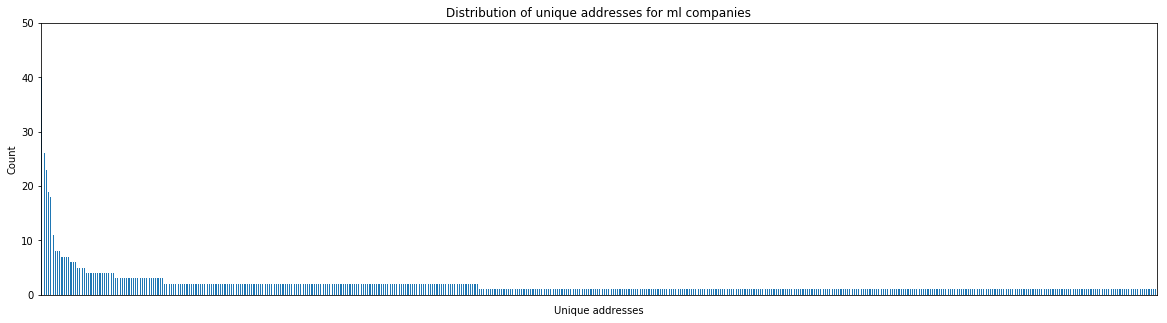

In [175]:
# Examine distribution of companies registered at an address for non-suspicious companies
address_count = pd.DataFrame({'address':np.unique(comps_df[comps_df.ml==0].address, return_counts=True)[0],
                             'count':np.unique(comps_df[comps_df.ml==0].address, return_counts=True)[1]})

fig, ax = plt.subplots(figsize=(20,5))
address_count.sort_values(by='count', ascending=False).head(500).plot(kind='bar', ax=ax)
ax.set_xticklabels(labels=[])
ax.set_xlabel('Unique addresses')
ax.set_ylabel('Count')
ax.set_title('Distribution of unique addresses for ml companies')
ax.set_ylim(0, 50)
ax.xaxis.set_ticks_position('none')
ax.get_legend().remove();

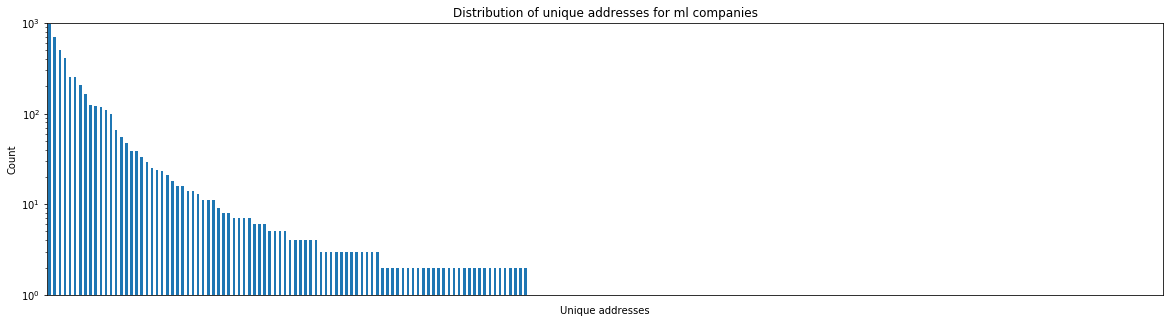

In [174]:
# Examine distribution of companies registered at an address for suspicious companies
address_count = pd.DataFrame({'address':np.unique(comps_df[comps_df.ml==1].address, return_counts=True)[0],
                             'count':np.unique(comps_df[comps_df.ml==1].address, return_counts=True)[1]})

fig, ax = plt.subplots(figsize=(20,5))
address_count.sort_values(by='count', ascending=False).plot(kind='bar', ax=ax)
ax.set_xticklabels(labels=[])
ax.set_xlabel('Unique addresses')
ax.set_ylabel('Count')
ax.set_title('Distribution of unique addresses for ml companies')
ax.set_yscale('log')
ax.set_ylim(0, 1000)
ax.xaxis.set_ticks_position('none')
ax.get_legend().remove();

There are markedly more addresses being used by multiple companies in the suspicious category and the number of companies using each address is significantly higher. This is frankly unsurprising as many suspicious companies will use a companies registration agent or "company factory" who will use a common address to avoid giving any personal address details. For most companies this is not neccessary because they will have an office or in the case of individuals or very small businesses they often register their home address and the number of cases where people use PO boxes or mail services makes up a very small proportion.

''

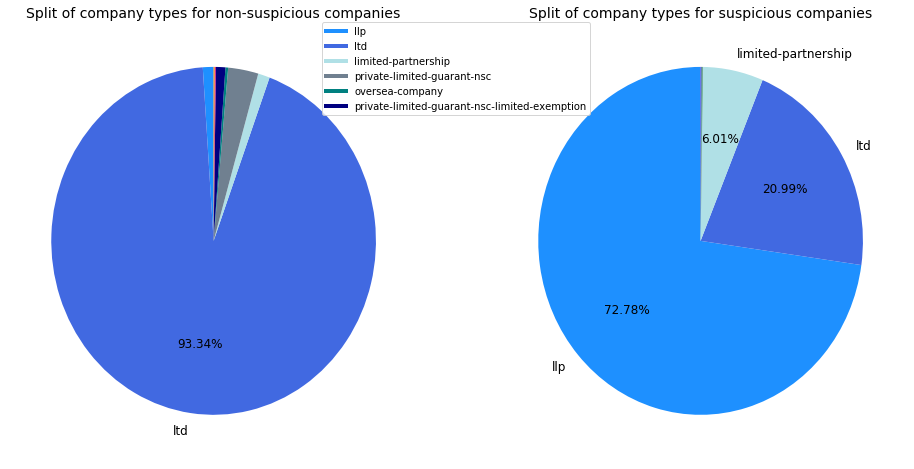

In [20]:
# Plot split of company types for both suspicious and non-suspicious
colours = ['dodgerblue','royalblue','powderblue','seagreen','slategray','teal','navy','mediumblue','darkviolet','mediumvioletred','darkorange']
label_threshold = 0.05

kind_count = pd.pivot_table(comps_df, values='active_officers', columns=['ml'],index=['kind'], aggfunc='count').sort_values(by=1, ascending=False)
kind_count.fillna(0, inplace=True)
kind_count['pct_0'] = kind_count[0]/sum(kind_count[0])
kind_count['pct_1'] = kind_count[1]/sum(kind_count[1])
pie_labels_0 = [kind_count.index[i] if list(kind_count['pct_0'])[i]>label_threshold else '' for i in range(len(kind_count))]
pie_labels_1 = [kind_count.index[i] if list(kind_count['pct_1'])[i]>label_threshold else '' for i in range(len(kind_count))]

def my_autopct(pct):
    return ('%.2f%%' % pct) if pct > label_threshold*100 else ''

fig, ax = plt.subplots(figsize=(16,8),ncols=2)
ax[0].pie(kind_count[0], labels=pie_labels_0, autopct=my_autopct, startangle=90, colors=colours, textprops={'fontsize': 12})
ax[1].pie(kind_count[1], labels=pie_labels_1, autopct=my_autopct, startangle=90, colors=colours, textprops={'fontsize': 12})
ax[0].set_title('Split of company types for non-suspicious companies',fontsize= 14)
ax[1].set_title('Split of company types for suspicious companies',fontsize= 14)

legend_labels = [kind_count.index[i] for i in range(len(kind_count)) if list(kind_count['pct_0'])[i]>0.002]
legend_colours = [colours[i] for i in range(len(kind_count)) if list(kind_count['pct_0'])[i]>0.002]
custom_lines = [Line2D([0], [0], color=colour, lw=4) for colour in legend_colours]
fig.legend(custom_lines, legend_labels, loc="center", bbox_to_anchor=(0.396, 0.695))
;

This shows the split of company types in the suspicious category is not in line with the overall population, where the majority of registered companies are Limited. This should not be a surprise because Limited Liability Partnerships (LLPs) and Limited Partnerships (LPs) due to their less stringent disclosure obligations, e.g. LPs are not required to submit accounts to Companies House if the partners are not liable to UK tax (which is also not checked). 

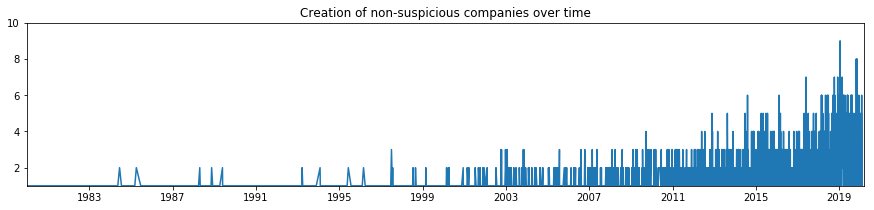

In [343]:
# Plot creation of non-suspicious companies over time

x = list(np.unique(comps_df[comps_df.ml==0].creation_date, return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==0].creation_date, return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(x, y, ax=ax)
ax.set_ylim(1,10)
ax.set_xlim([datetime(1980, 1, 1), datetime(2020,3,5)])
ax.set_title('Creation of non-suspicious companies over time');

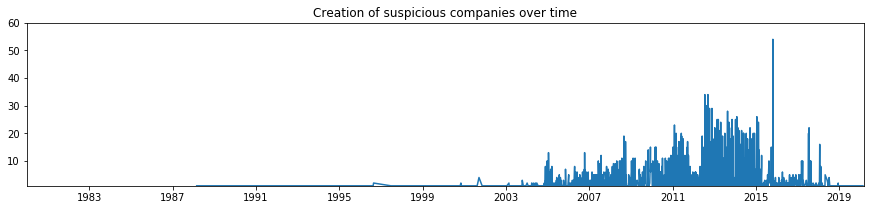

In [344]:
# Plot creation of ml companies over time
x = list(np.unique(comps_df[comps_df.ml==1].creation_date, return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==1].creation_date, return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.lineplot(x, y, ax=ax)
ax.set_ylim(1,60)
ax.set_xlim([datetime(1980, 1, 1), datetime(2020,3,5)])
ax.set_title('Creation of suspicious companies over time');

The formation of suspicious companies saw an increase in the early 2000s, as more stringent checks came in from Banks and AML investigations increased. There is also a sharp peak after 2015, this is when a large number of companies were registered as part of one of the larger Laundromats included in the positive samples. There appears to be a drop off in registrations of suspicious companies in more recent times, this misleading and most likely can be attributed to the bias in the positive samples being used. There are more cases of confirmed money laundering and financial crime in companies registered previously because the investigations can take a long time to unearth these rings. The data set used focuses on a number of large exposures of Laundromats over the period from 2013 to 2016, skewing the data to this timeframe.

''

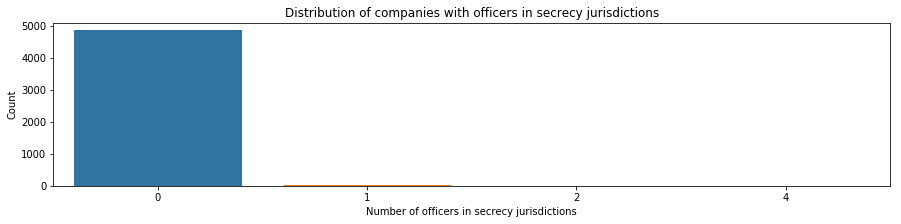

In [350]:
# Plot secrecy officers of non-ml companies
x = list(np.unique(comps_df[comps_df.ml==0]['secrecy_officers'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==0]['secrecy_officers'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax)
ax.set_xlabel('Number of officers in secrecy jurisdictions')
ax.set_ylabel('Count')
ax.set_title('Distribution of companies with officers in secrecy jurisdictions')
# ax.set_yscale('log')
;

''

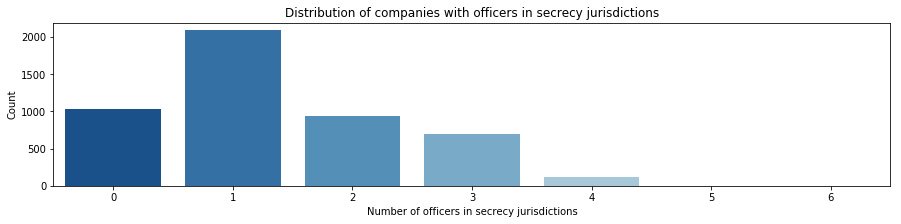

In [456]:
# Plot secrecy officers of ml companies 
x = list(np.unique(comps_df[comps_df.ml==1]['secrecy_officers'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==1]['secrecy_officers'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax, palette='Blues_r')
ax.set_xlabel('Number of officers in secrecy jurisdictions')
ax.set_ylabel('Count')
ax.set_title('Distribution of companies with officers in secrecy jurisdictions')
# ax.set_yscale('log')
;

It is uncommon for UK companies to have officers running them who are based in another country, there are not many reasons why this would be necessary and its even less likely for these "secrecy jurisdictions" given most of them are very small countries a long way from the UK. One reason, however, is that the law in these countries offers protection to individuals by maintaining their anonymity. This is obviously incredibly attractive to individuals looking to commit fraud and financial crime as when trying to trace the beneficiary of a shell company that has been found to be money laundering, the secrecy jurisdiction will not reveal their true identity.

''

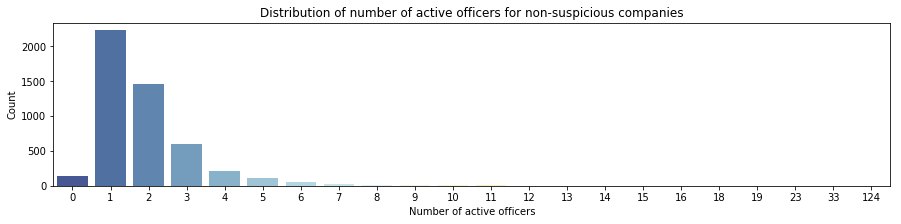

In [450]:
# Plot active officers of non-ml companies
x = list(np.unique(comps_df[comps_df.ml==0]['active_officers'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==0]['active_officers'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax, palette='RdYlBu_r')
ax.set_xlabel('Number of active officers')
ax.set_ylabel('Count')
ax.set_title('Distribution of number of active officers for non-suspicious companies')
;

''

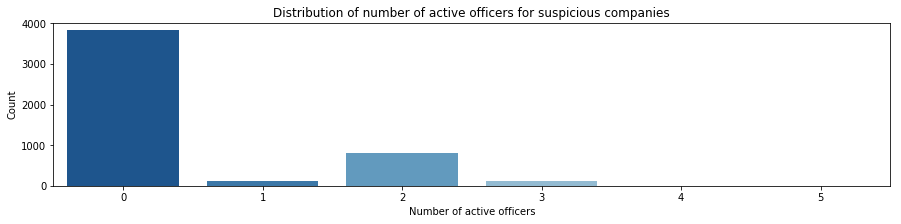

In [455]:
# Plot active officers of ml companies
x = list(np.unique(comps_df[comps_df.ml==1]['active_officers'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==1]['active_officers'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax,palette='Blues_r')
ax.set_xlabel('Number of active officers')
ax.set_ylabel('Count')
ax.set_title('Distribution of number of active officers for suspicious companies')
;

There's a distinct difference in the number of active officers for suspicious companies, where they will try to avoid declaring any officers where possible.

''

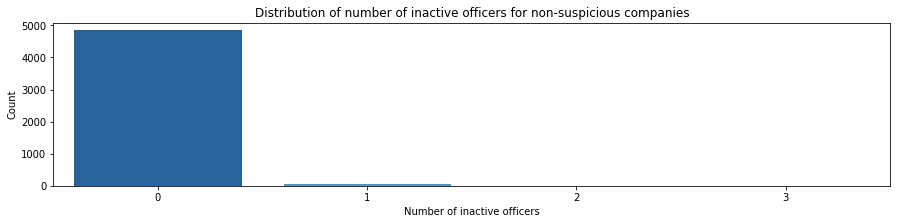

In [459]:
# Plot inactive officers of non-ml companies
x = list(np.unique(comps_df[comps_df.ml==0]['inactive_officers'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==0]['inactive_officers'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax, palette='Blues_r')
ax.set_xlabel('Number of inactive officers')
ax.set_ylabel('Count')
ax.set_title('Distribution of number of inactive officers for non-suspicious companies')
;

''

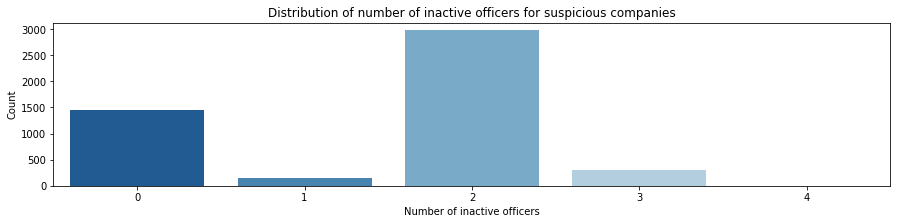

In [457]:
# Plot number of inactive officers of ml companies
x = list(np.unique(comps_df[comps_df.ml==1]['inactive_officers'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==1]['inactive_officers'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax,palette='Blues_r')
ax.set_xlabel('Number of inactive officers')
ax.set_ylabel('Count')
ax.set_title('Distribution of number of inactive officers for suspicious companies')
;

Having a higher number of inactive officers suggests lots of changes in officer and resignations, this is an unusual occurance for most companies but the data suggests it is more common amongst the suspicious companies.

''

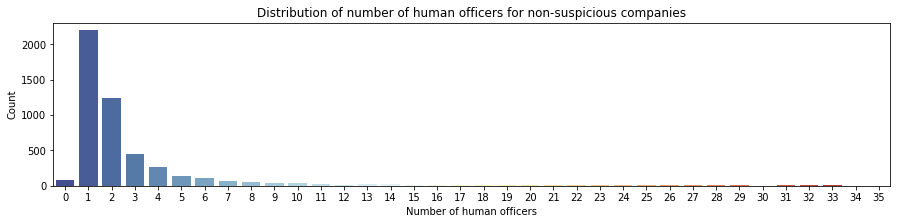

In [448]:
# Plot number of human officers for non-ml companies
x = list(np.unique(comps_df[comps_df.ml==0]['human_officers'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==0]['human_officers'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax, palette='RdYlBu_r')
ax.set_xlabel('Number of human officers')
ax.set_ylabel('Count')
ax.set_title('Distribution of number of human officers for non-suspicious companies')
;

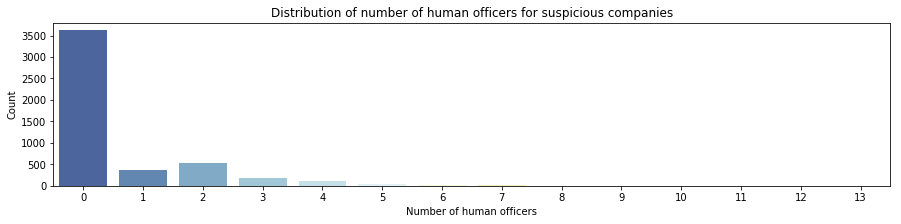

In [449]:
# Plot number of human officers for ml companies
x = list(np.unique(comps_df[comps_df.ml==1]['human_officers'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==1]['human_officers'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax, palette='RdYlBu_r')
ax.set_xlabel('Number of human officers')
ax.set_ylabel('Count')
ax.set_title('Distribution of number of human officers for suspicious companies')
plt.show()

Most companies from the population will have between 1 and 2 human officers actaully running the business, however the suspicious companies are unlikely to list any people as officers to avoid having to attribute the shell company to anyone.

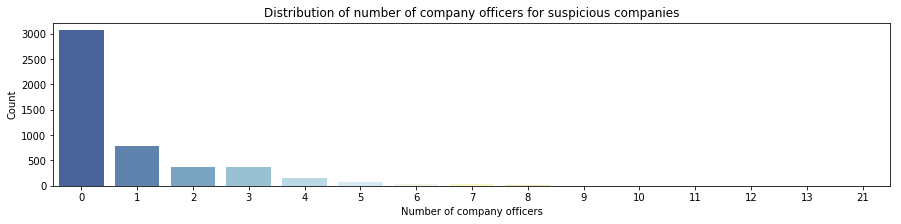

In [254]:
# Plot number of company officers for non-ml companies
x = list(np.unique(comps_df[comps_df.ml==0]['company_officers'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==0]['company_officers'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax, palette='RdYlBu_r')
ax.set_xlabel('Number of company officers')
ax.set_ylabel('Count')
ax.set_title('Distribution of number of company officers for suspicious companies')
plt.show()

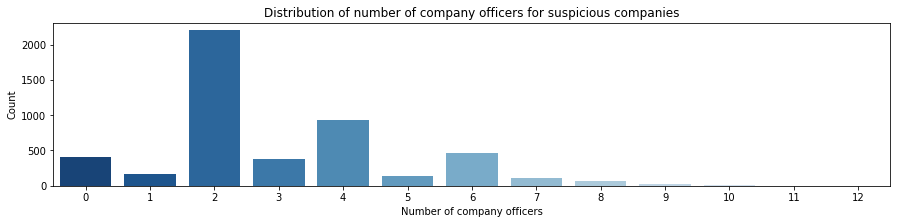

In [255]:
# Plot number of company officers for ml companies
x = list(np.unique(comps_df[comps_df.ml==1]['company_officers'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==1]['company_officers'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax, palette='Blues_r')
ax.set_xlabel('Number of company officers')
ax.set_ylabel('Count')
ax.set_title('Distribution of number of company officers for suspicious companies')
plt.show()

It is fairly uncommon for most companies to have a legal entity acting as an officer but for suspicious companies many have multiple "non-human" officers.

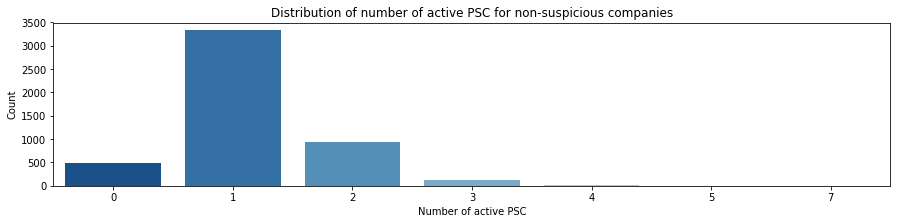

In [201]:
# Plot number of active psc for non-ml companies
x = list(np.unique(comps_df[comps_df.ml==0]['active_psc'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==0]['active_psc'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax, palette='Blues_r')
ax.set_xlabel('Number of active PSC')
ax.set_ylabel('Count')
ax.set_title('Distribution of number of active PSC for non-suspicious companies')
plt.show()

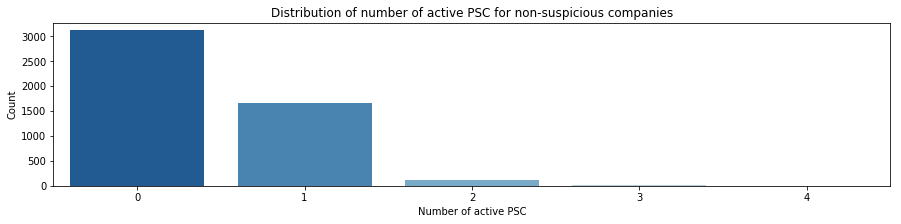

In [202]:
# Plot number of active psc for ml companies
x = list(np.unique(comps_df[comps_df.ml==1]['active_psc'], return_counts=True)[0])
y = list(np.unique(comps_df[comps_df.ml==1]['active_psc'], return_counts=True)[1])

fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(x, y, ax=ax, palette='Blues_r')
ax.set_xlabel('Number of active PSC')
ax.set_ylabel('Count')
ax.set_title('Distribution of number of active PSC for non-suspicious companies')
plt.show()

There is a clear pattern that suspicious companies are less likely to have active an PSC, since declaring a PSC became compulsory there is still an exemption to say you do not know who the ultimate PSC is. Again, this is not verified so it is an easy option for companies looking to conceal the identity of their beneficiary.

# Save and export

In [145]:
# Save dataframes externally
comps_df.to_csv('comps_df.csv', index=False)
officers_df.to_csv('officers_df.csv', index=False)
psc_df.to_csv('psc_df.csv', index=False)
filings_df.to_csv('filings_df.csv', index=False)

In [362]:
# Create new dataframe of features to be used for prediction
features_df = comps_df.copy()
features_df.drop(columns=['name', 'address', 'company_number', 'creation_date', 'dissolved_date'], inplace=True)

In [364]:
# Save new df with feature columns
features_df.to_csv('features_df.csv', index=False)